# Custom Models and Training with TensorFlow

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Tensors and Operations

In [10]:
t = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print(t)
print(t.shape)
print(t.dtype)


tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


In [12]:
print(t[:, 1:])
print(t[..., 1, tf.newaxis])


tf.Tensor(
[[2. 3.]
 [5. 6.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[2.]
 [5.]], shape=(2, 1), dtype=float32)


In [15]:
print(t + 10)
print(tf.square(t))
print(t @ tf.transpose(t))

tf.Tensor(
[[11. 12. 13.]
 [14. 15. 16.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[ 1.  4.  9.]
 [16. 25. 36.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[14. 32.]
 [32. 77.]], shape=(2, 2), dtype=float32)


In [16]:
from tensorflow import keras

K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

In [18]:
a = np.array([2.0, 4.0, 5.0])
t = tf.constant(a)
print(type(t))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [20]:
print(type(t.numpy()))

<class 'numpy.ndarray'>


In [21]:
tf.constant(b"hello tensor!")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello tensor!'>

In [23]:
s = tf.SparseTensor(
    indices=[[0, 1], [1, 0], [2, 3]], values=[1.0, 2.0, 3.0], dense_shape=[3, 4]
)
print(s)

print(tf.sparse.to_dense(s))

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))
tf.Tensor(
[[0. 1. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 3.]], shape=(3, 4), dtype=float32)


## Custom Loss Function

In [25]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


In [26]:
def huber_fn(y_true, y_pred):
    """Huber loss function between the true and predictive value of the given y"""
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)


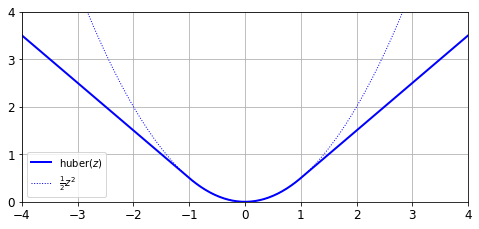

In [31]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)

plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label=r"huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^{2}$")

plt.axis([-4, 4, 0, 4])
plt.legend()
plt.grid()
plt.show()


In [33]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential(
    [
        keras.layers.Dense(
            30,
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=input_shape,
        ),
        keras.layers.Dense(1),
    ]
)

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [34]:
history = model.fit(
    X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid)
)


Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.6193 - mae: 0.9781 - val_loss: 0.2191 - val_mae: 0.5028
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2075 - mae: 0.4982 - val_loss: 0.1921 - val_mae: 0.4784


## Custom Layers

In [36]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1.0, 0.0, 1.0])


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787948, 1.        , 2.7182817 ], dtype=float32)>

In [37]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [38]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=input_shape),
        keras.layers.Dense(1),
        exponential_layer,
    ]
)

model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)


Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 4ms/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 3ms/step - loss: 0.3586


0.35863402485847473

In [42]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal",
        )
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros"
        )
        # Must build the super class at the end
        super().build(batch_input_shape)

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "units": self.units,
            "activation": keras.activations.serialize(self.activation),
        }


In [43]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [44]:
model = keras.models.Sequential(
    [
        MyDense(30, activation="relu", input_shape=input_shape),
        MyDense(1),
    ]
)

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)


Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.5474


0.5473727583885193